
--- Defining Features and Target ---
Target variable: expense_type
Feature columns: ['amount', 'date', 'category', 'description/merchant']

--- Preprocessing Data (with Normalization) ---

Preprocessing complete. Shape of X: (1531, 4), Shape of y: (1531,)
Final features used in X: ['amount', 'DayOfWeek', 'category_enc', 'description/merchant_enc']
Target classes encoded: ['need', 'want']

=== Evaluating Models using 5-Fold Cross-Validation ===

--- Evaluating KNN (k=3) ---
Mean 5-Fold CV Accuracy: 0.9464

--- Evaluating Decision Tree (max_depth=5) ---
Mean 5-Fold CV Accuracy: 0.9353

--- Evaluating Gaussian Naive Bayes ---
Mean 5-Fold CV Accuracy: 0.7100

--- Evaluating Logistic Regression ---
Mean 5-Fold CV Accuracy: 0.6160

--- Evaluating Support Vector Machine (Linear) ---
Mean 5-Fold CV Accuracy: 0.6114

--- Evaluating Random Forest (n_estimators=100) ---
Mean 5-Fold CV Accuracy: 0.9895

--- Cross-Validation Results Summary ---
Random Forest (n_estimators=100): 0.9895
KNN (k=3): 0

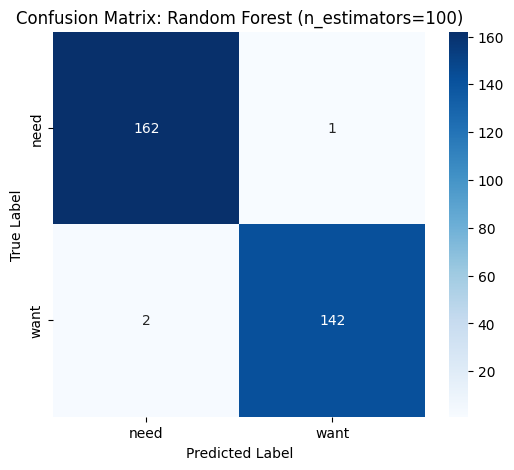


--- Exporting Model Assets ---
All artifacts saved:
 - expense_classifier_model.joblib
 - expense_scaler.joblib
 - expense_target_label_encoder.joblib
 - expense_category_label_encoder.joblib
 - expense_merchant_label_encoder.joblib


In [ ]:
import pandas as pd
import numpy as np
from io import StringIO
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import joblib

df_expenses = pd.read_csv("datasets/training_expenses.csv")

# --- Preprocessing Function (Adapted for Expenses) ---
def preprocess_expense_df(df, feature_cols, target_col="expense_type", normalize=False):
    """
    Preprocesses the expense DataFrame for modeling.

    Transformations:
        - Converts 'date' to datetime and then to an ordinal numerical value.
        - Applies LabelEncoder to categorical columns: 'category', 'description/merchant'.
        - Converts 'amount' to numeric (already likely is, but ensures it).
        - Transforms the target 'expense_type' using LabelEncoder.
        - Removes rows with NaN values in selected features or target.
        - If normalize=True, applies StandardScaler to the final feature matrix X.

    Returns:
        X: matrix of features
        y: vector of the encoded target.
        le_target: the LabelEncoder used for the target.
        final_feature_names: list of names of the columns in X.
        scaler: the StandardScaler object if normalize=True, else None.
    """
    df = df.copy()
    le_target = LabelEncoder()
    scaler = None

    # --- Feature Engineering ---

    # 1. Date -> DayOfWeek Conversion  # <<< MODIFIED COMMENT
    if 'date' in feature_cols:
        original_date_col = df['date'].copy() # Keep original for potential debugging
        try:
            # Attempt standard YYYY-MM-DD parsing first
            # Create a temporary datetime column
            df['date_dt'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='raise') # <<< MODIFIED (new temp col name)
            # Extract DayOfWeek (Mon=0, Sun=6) from the datetime column
            df['DayOfWeek'] = df['date_dt'].dt.dayofweek # <<< MODIFIED (extract DayOfWeek)
        except ValueError:
            # Add fallbacks for other common formats if needed
            try:
                # Create a temporary datetime column
                df['date_dt'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce') # <<< MODIFIED (new temp col name)
                # Extract DayOfWeek (Mon=0, Sun=6) from the datetime column
                df['DayOfWeek'] = df['date_dt'].dt.dayofweek # <<< MODIFIED (extract DayOfWeek)
            except Exception as e:
                print(f"Warning: Could not parse 'date' column. It might be dropped or cause errors. Error: {e}")
                df['date_dt'] = pd.NaT # Assign NaT if parsing fails
                df['DayOfWeek'] = np.nan # Ensure DayOfWeek column exists as NaN

    # Optional: Check if NaNs were produced from parsing/extraction
    if 'DayOfWeek' in df and df['DayOfWeek'].isnull().any():
         # Find original date values that resulted in NaN DayOfWeek
         nan_dates = original_date_col[df['DayOfWeek'].isnull()]
         if not nan_dates.empty:
             print(f"Warning: Could not determine day of week for some dates: {nan_dates.unique().tolist()}")
    elif 'DayOfWeek' not in df:
         # This case handles if 'date' was in feature_cols but parsing failed entirely in the try block
         print("Warning: 'DayOfWeek' column could not be created due to date parsing errors.")
         df['DayOfWeek'] = np.nan # Ensure column exists if expected

    # 2. Categorical Encoding
    categorical_cols_to_encode = ['category', 'description/merchant']
    encoders = {}
    for col in categorical_cols_to_encode:
        if col in feature_cols:
            le = LabelEncoder()
            # Handle potential NaN values before encoding
            df[col] = df[col].fillna('Missing') # Replace NaN with a placeholder string
            df[col + '_enc'] = le.fit_transform(df[col])
            encoders[col] = le # Store encoder if needed later

    # 3. Target Encoding
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")
    df[target_col] = df[target_col].fillna('Missing') # Handle potential NaN in target
    df[target_col + '_enc'] = le_target.fit_transform(df[target_col])

    # --- Feature Selection and Final Matrix Assembly ---

    # Map original feature names to their transformed versions
    feature_map = {}
    if 'date' in feature_cols: feature_map['date'] = 'DayOfWeek' # <<< MODIFIED (map to DayOfWeek)
    for col in categorical_cols_to_encode:
        if col in feature_cols:
            feature_map[col] = col + '_enc'
    # Note: 'amount' remains 'amount' unless specific transformation is needed

    # Build X cols
    X_cols_final = []
    for col in feature_cols:
        if col in feature_map:
            X_cols_final.append(feature_map[col])
        else:
            # ensure numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            X_cols_final.append(col)

    # Drop any NaNs
    df.dropna(subset=X_cols_final + [target_col + '_enc'], inplace=True)

    X = df[X_cols_final].values
    y = df[target_col + '_enc'].values

    # Optional scaling
    if normalize and X.size > 0:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # **NOW RETURN `encoders`** so we can save them
    return X, y, le_target, X_cols_final, scaler, encoders

# --- Model Evaluation Function (Mostly Unchanged) ---
def evaluate_model(X, y, model, cv_folds=None):
    """
    Evaluates the model using train/test split or cross-validation.

    Returns:
        If cv_folds is None: (accuracy, precision_macro, recall_macro, confusion_matrix)
        If cv_folds is an integer: Mean cross-validation accuracy score (float)
    """
    if X.shape[0] < 5 : # Need a minimum number of samples
        warnings.warn(f"Insufficient data for evaluation ({X.shape[0]} samples). Returning NaN scores.")
        if cv_folds is None:
            return (np.nan, np.nan, np.nan, np.array([]))
        else:
            return np.nan

    if cv_folds is None:
        # Train/Test Split (80/20)
        # Stratify if possible (at least 2 samples per class)
        stratify_param = y if len(np.unique(y)) > 1 and np.min(np.bincount(y)) >= 2 else None
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify_param)
        except ValueError as e:
            warnings.warn(f"Stratification failed: {e}. Splitting without stratification.")
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        if X_train.shape[0] == 0 or X_test.shape[0] == 0:
            warnings.warn("Train or test split resulted in zero samples. Cannot evaluate.")
            return (np.nan, np.nan, np.nan, np.array([]))

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        # Use zero_division=0 to handle cases where a class might not be predicted
        prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
        cm = confusion_matrix(y_test, y_pred)
        return (acc, prec, rec, cm)
    else:
        # K-Fold Cross-Validation
        n_samples = X.shape[0]
        # Ensure cv_folds is not more than n_samples
        actual_folds = min(cv_folds, n_samples)
        if actual_folds < 2:
            warnings.warn(f"Cannot perform cross-validation with less than 2 folds (n_samples={n_samples}). Returning NaN.")
            return np.nan
        # Warn if folds had to be reduced
        if actual_folds != cv_folds:
             warnings.warn(f"Reduced number of CV folds from {cv_folds} to {actual_folds} due to limited samples ({n_samples}).")


        kf = KFold(n_splits=actual_folds, shuffle=True, random_state=42)
        # Use scoring='accuracy' and handle potential errors during CV
        try:
            # error_score='raise' helps debug issues within CV folds
            scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy', error_score='raise')
            return scores.mean() # Return the average accuracy across folds
        except Exception as e:
            warnings.warn(f"Error during cross-validation for model {type(model).__name__}: {e}. Returning NaN.")
            return np.nan


# --- Confusion Matrix Plotting Function (Unchanged) ---
def plot_confusion(cm, labels, title="Confusion Matrix"):
    """ Displays the confusion matrix using seaborn heatmap """
    if not isinstance(cm, np.ndarray) or cm.size == 0:
        print(f"Cannot plot confusion matrix for '{title}': Matrix is empty or invalid.")
        return
    # Ensure labels match the dimensions of the matrix
    if cm.shape[0] != len(labels) or cm.shape[1] != len(labels):
         print(f"Warning: Mismatch between confusion matrix dimensions ({cm.shape}) and labels ({len(labels)}). Using default numeric labels.")
         labels_to_use = list(range(cm.shape[0]))
    else:
         labels_to_use = labels

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_to_use, yticklabels=labels_to_use)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# --- Main Execution ---

try:
    print("\n--- Defining Features and Target ---")
    # Select all columns except the target as initial features
    all_columns = list(df_expenses.columns)
    target_variable = "expense_type"
    feature_columns = [col for col in all_columns if col != target_variable]
    print(f"Target variable: {target_variable}")
    print(f"Feature columns: {feature_columns}")

    # --- Preprocessing ---
    # Set normalize=True to scale features, which is often good for KNN
    print("\n--- Preprocessing Data (with Normalization) ---")
    X_processed, y_processed, label_encoder_target, final_features, scaler_obj, cat_encoders = preprocess_expense_df(
        df_expenses,
        feature_cols=feature_columns,
        target_col=target_variable,
        normalize=True
    )

    if X_processed.shape[0] > 0:
        print(f"\nPreprocessing complete. Shape of X: {X_processed.shape}, Shape of y: {y_processed.shape}")
        print(f"Final features used in X: {final_features}")
        print(f"Target classes encoded: {list(label_encoder_target.classes_)}")

        # --- Model Training and Evaluation using Cross-Validation ---
        print("\n=== Evaluating Models using 5-Fold Cross-Validation ===")

        models_to_evaluate = {
            "KNN (k=3)": KNeighborsClassifier(n_neighbors=3),
            "Decision Tree (max_depth=5)": DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=42),
            "Gaussian Naive Bayes": GaussianNB(),
            "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42), # Added Logistic Regression
            "Support Vector Machine (Linear)": SVC(kernel='linear', random_state=42, probability=False), # Added Linear SVM
            "Random Forest (n_estimators=100)": RandomForestClassifier(n_estimators=100, random_state=42) # Added Random Forest
        }

        cv_results = {}
        for name, model in models_to_evaluate.items():
            print(f"\n--- Evaluating {name} ---")
            # Use the evaluate_model function with cv_folds=5
            mean_cv_accuracy = evaluate_model(X_processed, y_processed, model, cv_folds=5)
            if not np.isnan(mean_cv_accuracy):
                 print(f"Mean 5-Fold CV Accuracy: {mean_cv_accuracy:.4f}")
                 cv_results[name] = mean_cv_accuracy
            else:
                 print("Cross-validation failed or produced NaN.")


        print("\n--- Cross-Validation Results Summary ---")
        if cv_results:
             for name, acc in sorted(cv_results.items(), key=lambda item: item[1], reverse=True):
                 print(f"{name}: {acc:.4f}")
        else:
             print("No successful cross-validation results obtained.")


        # --- Optional: Train/Test Split Evaluation for Confusion Matrix ---
        # Let's evaluate the best performing model (or just KNN) on a single split
        # to visualize its confusion matrix.
        best_model_name = max(cv_results, key=cv_results.get) if cv_results else "KNN (k=3)" # Fallback to KNN
        print(f"\n--- Evaluating '{best_model_name}' on a single Train/Test Split (for Confusion Matrix) ---")
        best_model = models_to_evaluate[best_model_name]

        # Use evaluate_model without cv_folds to get the confusion matrix
        eval_results = evaluate_model(X_processed, y_processed, best_model, cv_folds=None)

        if eval_results and not any(np.isnan(x) for x in eval_results[:3]): # Check if results are valid
            acc_split, prec_split, rec_split, cm_split = eval_results
            print(f"Results (80/20 Split): Accuracy={acc_split:.4f}, Precision={prec_split:.4f}, Recall={rec_split:.4f}")
            plot_confusion(cm_split, labels=label_encoder_target.classes_, title=f"Confusion Matrix: {best_model_name}")
        else:
             print(f"Could not evaluate {best_model_name} on train/test split (likely due to data issues).")

        # --- Exporting the Trained Model, Scaler, and Label Encoder ---
        print("\n--- Exporting Model Assets ---")

        try:
            # Save the trained model
            joblib.dump(best_model, "expense_classifier_model.joblib")
            if scaler_obj is not None:
                joblib.dump(scaler_obj, "expense_scaler.joblib")

            # Save the target encoder
            joblib.dump(label_encoder_target, "expense_target_label_encoder.joblib")

            # Save each categorical encoder separately
            joblib.dump(cat_encoders['category'], "expense_category_label_encoder.joblib")
            joblib.dump(cat_encoders['description/merchant'], "expense_merchant_label_encoder.joblib")

            print("All artifacts saved:")
            print(" - expense_classifier_model.joblib")
            print(" - expense_scaler.joblib")
            print(" - expense_target_label_encoder.joblib")
            print(" - expense_category_label_encoder.joblib")
            print(" - expense_merchant_label_encoder.joblib")

        except Exception as e:
             print(f"Error saving model assets: {e}")

    else:
        print("\nCannot proceed with model training: No data left after preprocessing.")

except FileNotFoundError:
    print("Error: Could not load data. If using a file, ensure it's in the correct path.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")
    import traceback
    traceback.print_exc()